# NIPS 2017 Figure 1

In [7]:
%run -i NIPS2017.ipynb

# FIGURE and GRID
FIG_HEIGHT_MM = 50
FIG_WIDTH_MM = FIG_WIDTH_MM  # set in NIPS2017 notebook to a default value for all figures
FIG_N_ROWS = 1
ROW_1_NCOLS = 3
ROW_1_HEIGHT_MM = FIG_HEIGHT_MM
ROW_1_WIDTH_COL_1_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_1_WIDTH_COL_2_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_1_WIDTH_COL_3_MM = FIG_WIDTH_MM / ROW_1_NCOLS

# PATHS
PANEL_A = PATH_DROPBOX_FIGS + 'fig1_a.svg'
PANEL_B = PATH_DROPBOX_FIGS + 'fig1_b.svg'
PANEL_C = PATH_DROPBOX_FIGS + 'fig1_c.svg'

## Panel A

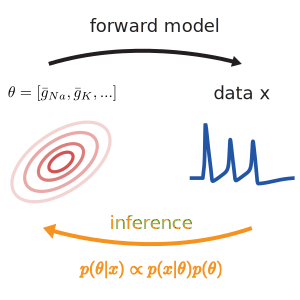

In [8]:
try:
    svg(PANEL_A)
except:
    pass

Panel a is drawn in Illustrator, and export as a `svg`.

Above we defined that row 1 col 1 has the following dimensions in mm:

In [ ]:
print('width : {:g}mm'.format(ROW_1_WIDTH_COL_1_MM))
print('height : {:g}mm'.format(ROW_1_HEIGHT_MM))

In Illustrator, it is advisable to work in units of `px`, however.

Panel a should have the following dimensions in pixels when working with illustrator/inkscape:

In [ ]:
print('width : {:g}px'.format(mm2px(ROW_1_WIDTH_COL_1_MM)))
print('height : {:g}px'.format(mm2px(ROW_1_HEIGHT_MM)))

Note: It's good to keep an `.ai` file for illustrator figures along, because fonts are only exported properly when `convert to outline` is choosen in the export dialog. However, we want to have them as texts as well, which is the reason for keeping an `.ai` file. 

## Panel B

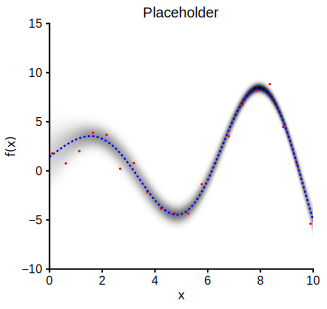

In [2]:
try:
    svg(PANEL_B)
except:
    pass

Panel b will illustrate theta space, x space, the kernel, and possibly the importance weights.

/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in sqrt


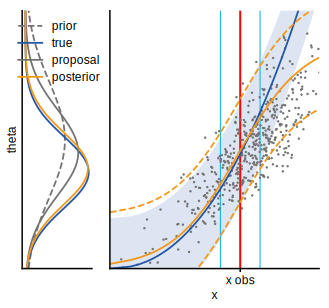

In [3]:
# no need toexecute unless you want regenerate panel_b

obs_stats=1.97

prior_cov=5
prior_mean=5.
noise_cov=0.1
eps = 0.3

prop_prior_cov=2.8
prop_prior_mean=4.5

post_mean = obs_stats**2
post_cov=2

true_cov = 1.95
true_mean = obs_stats**2-0.15

lims = np.array([[0],[10]])
n_grid_art = 100
yy_art = np.linspace(lims[0], lims[1], n_grid_art)

mu_brut_post_art = 0.*yy_art
eps_brut_post_art = 0.*yy_art
xx_art = 0.*yy_art
x0_grid_art = np.sqrt(yy_art)

###############################################################################
# gaussian density function
def gauss1D(x,mean,var):
    return ((2 * np.pi) ** (-0.5)) * (1 / np.sqrt(var)) * np.exp(-0.5 * ((x - mean) ** 2) / var)

###############################################################################
# sampling from proposal prior and running forward model
n_samp = 500
theta_samp = np.sqrt(prop_prior_cov)*np.random.randn(n_samp) + prop_prior_mean
x_samp = np.sqrt(noise_cov)*np.random.randn(n_samp)+np.sqrt(theta_samp)

###############################################################################
# contour values for prior, true posterior and estimated posterior
pp_prior_art = gauss1D(yy_art,prior_mean,prior_cov)
prop_prior_art = gauss1D(yy_art,prop_prior_mean,prop_prior_cov)
pp_estimated_art = gauss1D(yy_art,post_mean,post_cov)
pp_true_xo_art = gauss1D(yy_art,true_mean,true_cov)

###############################################################################
# posterior estimated for all x
y_estimated_x_art = np.divide(2*obs_stats**2.2,1+np.exp(-2*x0_grid_art+1.97*obs_stats))



# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(ROW_1_WIDTH_COL_2_MM), SCALE_IN*mm2inches(ROW_1_HEIGHT_MM))

with mpl.rc_context(fname=MPL_RC):

    plt.figure(figsize=fig_inches)
    ax = plt.subplot()

    col_0 = (35/255,86/255,167/255)
    col_1 = (0, 174/255,239/255)
    col_2 = (244/255, 152/255, 25/255)

    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 3])

    ax = plt.subplot(gs[0])
    plt.plot(pp_prior_art,yy_art,'--',color='0.45', label='prior')
    plt.plot(pp_true_xo_art,yy_art,color=col_0, label='true')
    plt.plot(prop_prior_art,yy_art,color='0.45', label='proposal')
    plt.plot(pp_estimated_art,yy_art,color=col_2, label='posterior')
    ax.set_ylim(lims)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.ylabel('theta')
    plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')

    ax = plt.subplot(gs[1])
    lims1 = np.array([[np.sqrt(lims[0,0]),np.sqrt(lims[1,0])],[lims[0,0],lims[1,0]]])
    plt.plot(x_samp, theta_samp,'.',color='0.45')
    plt.plot(x0_grid_art, yy_art**1.1, color = col_0, label='true posterior')
    plt.fill_between(x0_grid_art,yy_art**1.1-true_cov,
                     yy_art**1.1+true_cov,
                     facecolor=col_0,
                     alpha=0.15)

    plt.plot(x0_grid_art,y_estimated_x_art,color=col_2)
    plt.plot(x0_grid_art,y_estimated_x_art+post_cov,'--',color=col_2)
    plt.plot(x0_grid_art,y_estimated_x_art-post_cov,'--',color=col_2)
    ax.vlines(obs_stats, 0, ax.get_ylim()[1], lw=2, color='r')
    ax.vlines(obs_stats-eps, 0, ax.get_ylim()[1], lw=1, color=col_1)
    ax.vlines(obs_stats+eps, 0, ax.get_ylim()[1], lw=1, color=col_1)

    ax.set_xlim(np.sqrt(lims))
    ax.set_ylim(lims)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.xlabel('x')

    plt.xticks([obs_stats], ['x obs'])

    plt.tight_layout()

    plt.savefig(PANEL_B, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()

svg(PANEL_B)

Checking the dimensions of the resulting file:

In [ ]:
panel = st.fromfile(PANEL_B)
width, height = panel.get_size()
print('size of svg : {}'.format((width, height)))
print('aspect ratio : {}'.format(get_num(width) / get_num(height)))
print('desired ratio : {}'.format(ROW_1_WIDTH_COL_2_MM / ROW_1_HEIGHT_MM))

## Panel C

In [ ]:
try:
    svg(PANEL_C)
except:
    pass

## Put together figure

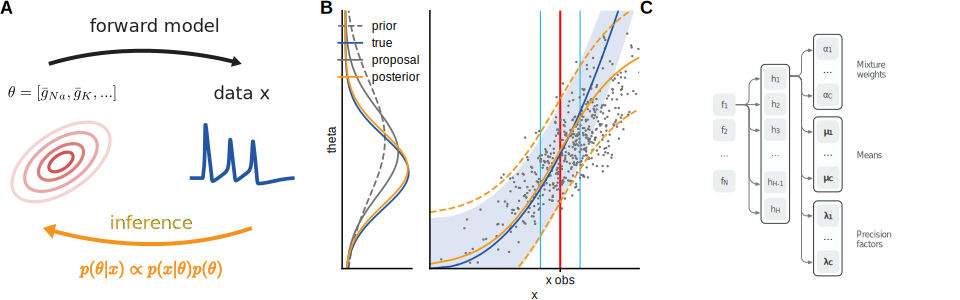

In [9]:
fig = create_fig(FIG_WIDTH_MM, FIG_HEIGHT_MM)
if False:  # set to False to disable grid
    fig = add_grid(fig, 10, 10)
    fig = add_grid(fig, 160/3, 10, font_size_px=0.0001)
fig = add_svg(fig, PANEL_A, 0, 0)
fig = add_svg(fig, PANEL_B, ROW_1_WIDTH_COL_1_MM, 0)
fig = add_svg(fig, PANEL_C, ROW_1_WIDTH_COL_1_MM + ROW_1_WIDTH_COL_2_MM, 0, scale=1.5)

fig = add_label(fig, 'A', 0*160/3, 2.3)
fig = add_label(fig, 'B', 1*160/3, 2.3)
fig = add_label(fig, 'C', 2*160/3, 2.3)

PATH_SVG = PATH_DROPBOX_FIGS + 'fig1.svg'
fig.save(PATH_SVG)

svg(PATH_SVG)

!$INKSCAPE --export-pdf $PATH_DROPBOX_FIGS/fig1.pdf $PATH_SVG